# HRV Parameter Extraction
This notebook is used for analysing significance of patient HRV parameters extracted in part 4. 

To do:
- Apply chi and Mann-Whitney tests to parameters
- (optional) restructure the db to be multiindexed??
- Test classification algorithms to set a range for CAN vs control patients...

## Initial setup

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pyarrow.feather as feather
from tqdm import tqdm

In [4]:
#root = 'G:\My Drive\Molecool\Databases\Database1'
root = '/Volumes/GoogleDrive/.shortcut-targets-by-id/1sZgDE1M3o-bDINfAQYEXl_vqsKs03WxD/Molecool/Databases/Database1'

## Functions

In [5]:
def check_clean_valid(path):
    """Only indicates that the folder is valid if it contains a file named 'CleanParameters.json'
    Input: Filepath
    Output: True if the folder indexed by the filepath contains a file called CleanParameters.json, False otherwise"""
    return os.path.exists(path + '/CleanParameters.json')

In [6]:
def collect_row(parapath, patient, count):
    """"""
    with open(parapath + '/CleanParameters.json') as json_file:
        row = json.load(json_file)
        json_file.close()
        
    row['Patient'] = patient
    row['Count'] = count[-3:]
    print(row)
    return row

In [16]:
def lookup_patient(paradf, root):
    """Adds patient classifications (diabetic vs control, CAD vs no CAD) by...
    ...looking up values in the small metadata file (sdf) associated with the...
    ..database and editing the parameter dataframe accordingly
    Input: DataFrame of Parameters (paradf), root of the database (root)
    Output: Edited paradf"""
    # Load the Small Metadata file
    #with open(root + '\\SMeta.json') as json_file:
    with open(root + '/SMeta.json') as json_file:
        sdf = pd.read_json(json_file, orient = 'index')
        json_file.close()
    
    # Add DM/C classification
    paradf['CAD'] = (sdf.loc[paradf['Patient']]['CAN Symptoms']).reset_index(drop=True)
    
    # Add CAN/Not classification
    paradf['Diabetic'] = (sdf.loc[paradf['Patient']]['Diabetic']).reset_index(drop=True)
    
    return paradf

In [17]:
#def to_df(rows):
 #   """Converts the collected dictionary rows into a ... and reformats it so that it's indexed """

## Initial Analysis of clean HRV Snippet Parameters
### Load All parameters and classification into DF

In [18]:
rows = []

patients = sorted(os.listdir(root))
for pat in tqdm(patients):     #Looping throught the folder Sxxxx
    if not pat.endswith(('.json', 'ini','\r')):
        path_pat = root+'/'+pat
        folders = sorted(os.listdir(path_pat))
        for folder in folders:    #Looping through the different ecg types 
            if not folder.endswith('.ini') and folder != 'Icon\r':
                path_folder = path_pat + '/' +folder   
                snippets = sorted(os.listdir(path_folder))
                for snip_folder in snippets:  #Looping through the snippet folders
                    if not snip_folder.endswith(('.json', '.ftr', '.ini','\r')):
                        print("In snippet folder " + snip_folder)
                        
                        ### NOW IN CORRECT FOLDER ###
                        path_snip =path_folder + '/' + snip_folder
                        if check_clean_valid(path_snip):
                            rows.append(collect_row(path_snip, pat, snip_folder))
                            print('\n\n')

 29%|████████████                              | 16/56 [00:00<00:00, 155.66it/s]

In snippet folder Snippet000
In snippet folder Snippet001
{'SDNN': 9.388711176710585, 'RMSSD': 3.7275644651843733, 'PNN50': 0.0, 'LF': 6.972244720053225, 'HF': 5.05258479487378, 'LFHF': 1.3799362114866596, 'Patient': 'S0250', 'Count': '001'}



In snippet folder Snippet002
In snippet folder Snippet000
In snippet folder Snippet000
{'SDNN': 19.93502977681763, 'RMSSD': 11.883778830332387, 'PNN50': 0.0, 'LF': 13.341491259583142, 'HF': 19.309388679624874, 'LFHF': 0.6909328659203482, 'Patient': 'S0273', 'Count': '000'}



In snippet folder Snippet001
{'SDNN': 23.382226136845293, 'RMSSD': 13.006798668165926, 'PNN50': 0.0, 'LF': 19.026568875603836, 'HF': 24.836171091050836, 'LFHF': 0.7660830168165349, 'Patient': 'S0273', 'Count': '001'}



In snippet folder Snippet002
{'SDNN': 63.1055109941366, 'RMSSD': 82.24981476252546, 'PNN50': 0.3546099290780142, 'LF': 13.725900026784812, 'HF': 24.00461959671393, 'LFHF': 0.5718024387549051, 'Patient': 'S0273', 'Count': '002'}



In snippet folder Snippet00

100%|██████████████████████████████████████████| 56/56 [00:00<00:00, 142.36it/s]




In snippet folder Snippet002
In snippet folder Snippet000
{'SDNN': 34.44213214880959, 'RMSSD': 12.232309388306282, 'PNN50': 0.6369426751592357, 'LF': 31.81360220854277, 'HF': 20.59657984193521, 'LFHF': 1.5446060682254337, 'Patient': 'S0372', 'Count': '000'}



In snippet folder Snippet001
In snippet folder Snippet002
In snippet folder Snippet000
In snippet folder Snippet001
In snippet folder Snippet002
{'SDNN': 43.8737033199043, 'RMSSD': 57.919661084039056, 'PNN50': 0.7920792079207921, 'LF': 13.570441344916333, 'HF': 13.186894495732492, 'LFHF': 1.029085456724323, 'Patient': 'S0381', 'Count': '002'}



In snippet folder Snippet000
In snippet folder Snippet000
In snippet folder Snippet001
In snippet folder Snippet002
{'SDNN': 43.18540285327933, 'RMSSD': 54.32710881646028, 'PNN50': 0.22075055187637968, 'LF': 31.555378978866067, 'HF': 20.68561108919948, 'LFHF': 1.525474826090199, 'Patient': 'S0390', 'Count': '002'}



In snippet folder Snippet000
In snippet folder Snippet001
In snippet 

In [19]:
# Convert collected parameters into dataframe
df = pd.DataFrame(rows)

In [20]:
def clean_sMeta(root):
    """Reformats data in small MetaData file and saves it.
    Input: Filepath for the folder the small MetaData file is in"""
    #with open(root + '\\SMeta.json') as json_file:
    with open(root + '/SMeta.json') as json_file:
        sdf = pd.read_json(json_file, orient = 'index')
        
        # Set CAN classification to bool through mapping
        #d = {'NO': False, 'YES': True}
        #sdf['CAN Symptoms'] = sdf['Neuropathy AUTONOMIC SYMPTOMS'].map(d)
        sdf['CAN Symptoms'] = sdf['Neuropathy AUTONOMIC SYMPTOMS']
        
        # Set DM/Control classification to bool through mapping
        d = {'DM': True, 'CONTROL': False}
        sdf['Diabetic'] = sdf['Group'].map(d)
        
        # Drop unnecessary columns
        sdf.drop(columns=['Group'])
        sdf.drop(columns=['Neuropathy AUTONOMIC SYMPTOMS'])
        
        # Save edited dataframe
        sdf.to_json((root + '/SMeta.json'), orient='index')
        json_file.close()
        print(sdf)
    return

In [21]:
clean_sMeta(root)

         Group  Diabetes Duration  age        BMI  Hb A1C%  CRP (mg/L)  \
S0250       DM                7.0   50  35.782279      9.4       0.240   
S0254  CONTROL                0.0   69  24.275148      5.1       0.104   
S0256       DM               23.0   65  29.629630      7.1       0.060   
S0264       DM               26.0   66  33.184005      6.6       0.061   
S0273       DM               16.0   68  26.276710      6.5       0.084   
S0282       DM                1.0   62  26.762951      5.4       0.140   
S0283  CONTROL                0.0   83  21.204120      5.9       0.028   
S0287       DM               18.0   73  19.909313      9.1         NaN   
S0288       DM                2.0   73  25.580540      6.2         NaN   
S0292       DM                5.0   66  25.691406      6.4         NaN   
S0296       DM                9.0   71  26.268814      7.2         NaN   
S0300       DM               10.0   67  27.072144      7.1       0.032   
S0301       DM               21.0   65

In [22]:
lookup_patient(df, root)

,SDNN,RMSSD,PNN50,LF,HF,LFHF,Patient,Count,CAD,Diabetic
0,9.388711,3.727564,0.000000,6.972245,5.052585,1.379936,S0250,001,False,True
1,19.935030,11.883779,0.000000,13.341491,19.309389,0.690933,S0273,000,True,True
2,23.382226,13.006799,0.000000,19.026569,24.836171,0.766083,S0273,001,True,True
3,63.105511,82.249815,0.354610,13.725900,24.004620,0.571802,S0273,002,True,True
4,30.022832,17.002152,1.612903,20.888081,14.231384,1.467748,S0282,002,False,True
5,8.048376,1.886577,0.000000,1.948780,3.007181,0.648042,S0283,002,True,False
6,44.351059,62.740660,0.299401,6.989108,14.514825,0.481515,S0288,001,False,True
7,8.737276,3.430068,0.000000,5.611292,4.736355,1.184728,S0300,001,False,True
8,31.674669,43.212536,0.301205,9.999720,8.540746,1.170825,S0310,000,True,True
9,11.532271,2.453353,0.000000,12.794287,4.941024,2.589400,S0317,000,True,True


### Initial plots

In [26]:
# Separating Dataframes
DM_df = df.loc[df['Diabetic']]

Control_df = df.loc[df['Diabetic'] == False]

CAN_df = df.loc[df['CAD']]

nCAN_df = df.loc[df['CAD'] == False]

IndexError: list index out of range

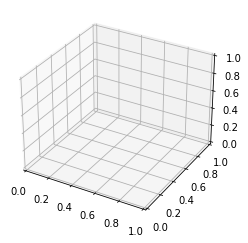

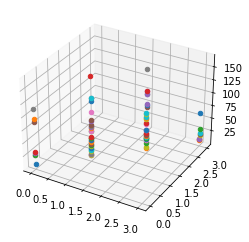

In [34]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')

x = np.arange(0,10,1)
y = np.arange(0,10,1)

z1 = Control_df['SDNN']
z4 = CAN_df['SDNN']
z3 = nCAN_df['SDNN']
z2 = DM_df['SDNN']

zs = [
    z1, z2, z3, z4
]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, x_i in enumerate(x):
    for z_ij in zs[i]:
        ax.scatter(xs=x_i, ys=y[i], zs=z_ij, zdir='z')
plt.show()

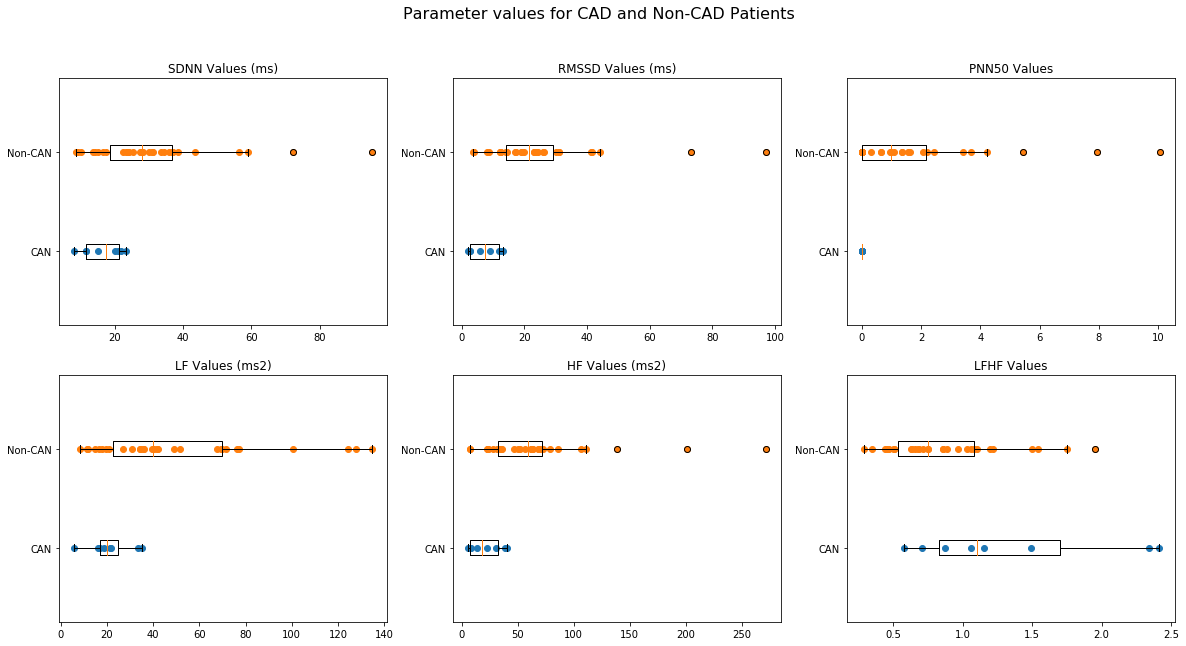

In [145]:
fig, axs = plt.subplots(2,3, figsize=(20,10))

fig.suptitle('Parameter values for CAD and Non-CAD Patients', fontsize=16)

lst = [1] * len(CAN_df['RMSSD'])
lst2 = [2] * len(nCAN_df['RMSSD'])

groups = ('CAN', 'Non-CAN')

axs[0, 0].scatter(CAN_df['SDNN'], lst)
axs[0, 0].scatter(nCAN_df['SDNN'], lst2)
axs[0, 0].boxplot([CAN_df['SDNN'], nCAN_df['SDNN']], vert = False)
axs[0,0].set_ylim([0.25, 2.75])
axs[0,0].set_yticks((1,2))
axs[0,0].set_yticklabels(groups)
axs[0,0].set_title('SDNN Values (ms)')

axs[0, 1].scatter(CAN_df['RMSSD'], lst)
axs[0, 1].scatter(nCAN_df['RMSSD'], lst2)
axs[0, 1].boxplot([CAN_df['RMSSD'], nCAN_df['RMSSD']], vert = False)
axs[0,1].set_ylim([0.25, 2.75])
axs[0,1].set_yticks((1,2))
axs[0,1].set_yticklabels(groups)
axs[0,1].set_title('RMSSD Values (ms)')

axs[0, 2].scatter(CAN_df['PNN50'], lst)
axs[0, 2].scatter(nCAN_df['PNN50'], lst2)
axs[0, 2].boxplot([CAN_df['PNN50'], nCAN_df['PNN50']], vert = False)
axs[0,2].set_ylim([0.25, 2.75])
axs[0,2].set_yticks((1,2))
axs[0,2].set_yticklabels(groups)
axs[0,2].set_title('PNN50 Values')

axs[1, 0].scatter(CAN_df['LF'], lst)
axs[1, 0].scatter(nCAN_df['LF'], lst2)
axs[1, 0].boxplot([CAN_df['LF'], nCAN_df['LF']], vert = False)
axs[1,0].set_ylim([0.25, 2.75])
axs[1,0].set_yticks((1,2))
axs[1,0].set_yticklabels(groups)
axs[1,0].set_title('LF Values (ms2)')

axs[1, 1].scatter(CAN_df['HF'], lst)
axs[1, 1].scatter(nCAN_df['HF'], lst2)
axs[1, 1].boxplot([CAN_df['HF'], nCAN_df['HF']], vert = False)
axs[1,1].set_ylim([0.25, 2.75])
axs[1,1].set_yticks((1,2))
axs[1,1].set_yticklabels(groups)
axs[1,1].set_title('HF Values (ms2)')

axs[1,2].scatter(CAN_df['LFHF'], lst)
axs[1,2].scatter(nCAN_df['LFHF'], lst2)
axs[1,2].boxplot([CAN_df['LFHF'], nCAN_df['LFHF']], vert = False)
axs[1,2].set_ylim([0.25, 2.75])
axs[1,2].set_yticks((1,2))
axs[1,2].set_yticklabels(groups)
axs[1,2].set_title('LFHF Values')
plt.show()

In [ ]:
axs[0, 0].boxplot([DM_df['SDNN'], Control_df['SDNN']], vert = False)

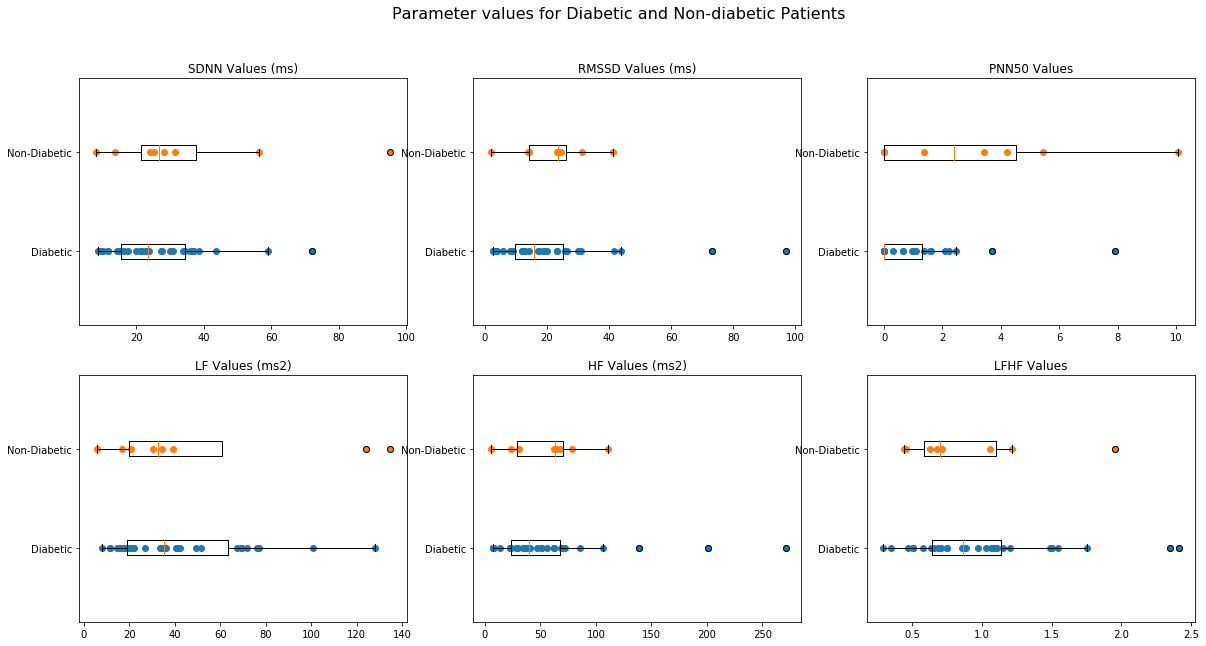

In [143]:
fig, axs = plt.subplots(2,3, figsize=(20,10))

fig.suptitle('Parameter values for Diabetic and Non-diabetic Patients', fontsize=16)

lst = [1] * len(DM_df['RMSSD'])
lst2 = [2] * len(Control_df['RMSSD'])

groups = ('Diabetic', 'Non-Diabetic')

axs[0, 0].scatter(DM_df['SDNN'], lst)
axs[0, 0].scatter(Control_df['SDNN'], lst2)
axs[0, 0].boxplot([DM_df['SDNN'], Control_df['SDNN']], vert = False)
axs[0,0].set_ylim([0.25, 2.75])
axs[0,0].set_yticks((1,2))
axs[0,0].set_yticklabels(groups)
axs[0,0].set_title('SDNN Values (ms)')

axs[0, 1].scatter(DM_df['RMSSD'], lst)
axs[0, 1].scatter(Control_df['RMSSD'], lst2)
axs[0, 1].boxplot([DM_df['RMSSD'], Control_df['RMSSD']], vert = False)
axs[0,1].set_ylim([0.25, 2.75])
axs[0,1].set_yticks((1,2))
axs[0,1].set_yticklabels(groups)
axs[0,1].set_title('RMSSD Values (ms)')

axs[0, 2].scatter(DM_df['PNN50'], lst)
axs[0, 2].scatter(Control_df['PNN50'], lst2)
axs[0, 2].boxplot([DM_df['PNN50'], Control_df['PNN50']], vert = False)
axs[0,2].set_ylim([0.25, 2.75])
axs[0,2].set_yticks((1,2))
axs[0,2].set_yticklabels(groups)
axs[0,2].set_title('PNN50 Values')

axs[1, 0].scatter(DM_df['LF'], lst)
axs[1, 0].scatter(Control_df['LF'], lst2)
axs[1, 0].boxplot([DM_df['LF'], Control_df['LF']], vert = False)
axs[1,0].set_ylim([0.25, 2.75])
axs[1,0].set_yticks((1,2))
axs[1,0].set_yticklabels(groups)
axs[1,0].set_title('LF Values (ms2)')

axs[1, 1].scatter(DM_df['HF'], lst)
axs[1, 1].scatter(Control_df['HF'], lst2)
axs[1, 1].boxplot([DM_df['HF'], Control_df['HF']], vert = False)
axs[1,1].set_ylim([0.25, 2.75])
axs[1,1].set_yticks((1,2))
axs[1,1].set_yticklabels(groups)
axs[1,1].set_title('HF Values (ms2)')

axs[1,2].scatter(DM_df['LFHF'], lst)
axs[1,2].scatter(Control_df['LFHF'], lst2)
axs[1,2].boxplot([DM_df['LFHF'], Control_df['LFHF']], vert = False)
axs[1,2].set_ylim([0.25, 2.75])
axs[1,2].set_yticks((1,2))
axs[1,2].set_yticklabels(groups)
axs[1,2].set_title('LFHF Values')
plt.show()